# Superdroplet experiments for Cloudy CES & Comparison
Box model setup with collision coalescence only. Given user-defined initial condition and kernel.

In [23]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../..'))

from PySDM.physics import si
from PySDM.physics.formulae import volume

## 1. Linear Kernel, gamma distribution

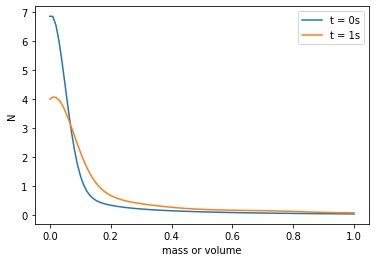

In [80]:
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity
from PySDM.initialisation.spectra import Gamma

n_sd = 2**13
initial_spectrum = Gamma(norm_factor=8.39e12, shape=0.0817, scale= 1.5597 * si.um**3)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)
kernel_b = 1/3.14/4

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.backends import CPU
from PySDM.products.state import ParticlesNumberVolumeSpectrum, KthMoment

builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=1 * si.s, dv=1e6 * si.m**3))
builder.add_dynamic(Coalescence(kernel=ConstKern(kernel_const = 0.01 / si.s)))
products = [ParticlesNumberVolumeSpectrum(), KthMoment()]
particles = builder.build(attributes, products)

from PySDM.physics.constants import rho_w
from matplotlib import pyplot
import numpy as np
from scipy import stats

v_bins_edges = np.logspace(np.log10(0.001 * si.um**3), np.log10(10.0 * si.um**3), num=50)

plot_opt = "kde"

for step in [0, 1]:
    particles.run(step - particles.n_steps)
    if (plot_opt == "kde"):
        final_counts = particles.products['N(v)'].get(v_bins_edges)
        n_drop_final = int(particles.products['Mk'].get(0))

        kde_pts = particles.particles.get_extensive_attrs().to_ndarray() / si.um**3
        kde = stats.gaussian_kde(kde_pts[0])

        x = np.linspace(0, 1.0, 100)
        y = kde(x)
        pyplot.plot(x ,y, label=f"t = {step}s")
    else:
        pyplot.step(x=v_bins_edges[:-1] / si.um**3,
                y=particles.products['N(v)'].get(v_bins_edges),
                where='post', label=f"t = {step}s")
                
#pyplot.xscale('log')
pyplot.xlabel('mass or volume')
pyplot.ylabel("N")
pyplot.legend()

In [ ]:
## Extract and plot the moments over time